# Code for Fig. SM5

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

from general_functions import (compute_energies, purcell_factor, complete_dynamics,
                               g0_fun, compute_shift)

## Single impurity (a)

### Analytical

In [17]:
pol_lat = np.array([[0, 1, 0]]).T
pol_emi = np.array([[1, 1, 0]]).T / np.sqrt(2)

d = 1
lambda0 = d / 0.3
k0 = 2 * np.pi / lambda0
aho = 0.1 * d

n = 2 ** 10 + 1
nmax = 9

b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])
A = d ** 2

G0 = g0_fun(k0, aho)

k_x = np.linspace(-np.pi, np.pi, n) / d
k_X, k_Y = np.meshgrid(k_x, k_x)

k = np.vstack((k_X.flatten(), k_Y.flatten())).T

x = np.arange(0, n) - n / 2 + d / 2
y = np.arange(0, n) - n / 2 + d / 2
x, y = np.meshgrid(x, y)
z = np.zeros((n, n))
r_lat = [x, y, z]

In [18]:
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=[pol_lat])
omega_k = (J - 0.5j * Gamma).reshape(n, n)

omega_q = np.real(omega_k).reshape(n, n)[n // 2, -1]

In [27]:
n_pos = 100  # Number of points

# The emitter is located in the diagonal (y = -x), and moves from the center
# of a plaquette up a distance of 0.5d from the center.

x_vector = -np.linspace(0.146, 0.5, n_pos) * d
y_vector = np.linspace(0.146, 0.5, n_pos) * d
z_vector = np.zeros(n_pos)

# Distance to the center of the plaquette. [Note that there is a array dipole at (0, 0)]
x_axis_vector_analytical = np.sqrt((x_vector[::-1] - x_vector[0]) ** 2 +
                                    (y_vector[::-1] - y_vector[0]) ** 2)

r_emi_vector = np.array([x_vector, y_vector, z_vector])

In [28]:
pbar = tqdm(range(n_pos), desc='Computing Purcell')
results = Parallel(n_jobs=-1, backend='multiprocessing')(
    delayed(purcell_factor)(r_lat, r_emi_vector[:, j], [k_X, k_Y],
                            omega_k, omega_q, k0, pol_lat, pol_emi) for j in pbar)

results = np.array(results)
optical_depth = results[:, 1] / results[:, 0]

Computing Purcell:   0%|          | 0/100 [00:00<?, ?it/s]

### Numerical

In [21]:
border = 15
max_gamma = 15

N_x = 60
N_y = N_x
x_pos = np.arange(0, N_x) - N_x / 2 + d / 2
y_pos = np.arange(0, N_y) - N_y / 2 + d / 2
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros(len(x_pos))
r_pos = [x_pos, y_pos, z_pos]

gamma_emi = 0.002
omega_emi = -0.999  # For d / lambda_0 = 0.3

dt = 2e-3 / gamma_emi
tf = dt * 2 ** 10

psi0 = np.zeros(len(x_pos) + 1)
psi0[-1] = 1

In [24]:
n_pos = 20
purcell_numerical = np.zeros(n_pos)

x_vector = np.linspace(0, 0.5, n_pos) * d / np.sqrt(2)
y_vector = -np.linspace(0, 0.5, n_pos) * d / np.sqrt(2)
z_vector = np.zeros(n_pos)

x_axis_vector_numerical = np.sqrt(x_vector ** 2 + y_vector ** 2)

r_emi_vector = np.array([x_vector, y_vector, z_vector])

pbar = tqdm(total=n_pos, desc='Computing dynamics')
for i in range(n_pos):
    emitter = [r_emi_vector[:, i]]
    
    results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, [pol_emi], gamma_emi,
                      omega_emi, border, max_gamma=max_gamma)
    
    purcell_numerical[i] = results['Q_n'][-1]
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/20 [00:00<?, ?it/s]

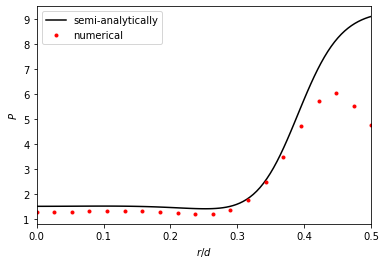

In [30]:
fig, ax = plt.subplots()
ax.plot(x_axis_vector_analytical, optical_depth, 'k', label='semi-analytically')
ax.plot(x_axis_vector_numerical, purcell_numerical, 'r.', label='numerical')

ax.set_xlim(0, 0.5)
ax.legend()
ax.set_xlabel(r'$r/d$')
ax.set_ylabel(r'$P$');

## Cluster (b-c)

In [49]:
pol_lat = np.array([[0, 1, 0]]).T
pol_emi = [np.array([[1, 1, 0]]).T / np.sqrt(2)] * 2

d = 1 # Wave-lenght of transition
lambda0 = d / 0.3 # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

border = 15 # Border of adiabatic lossees
max_gamma = 15  # Maximum individual free space decay rate in the border
r_circles = np.arange(border, border + 5)

N_x = 60
N_y = N_x
x_pos = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos = (np.arange(0, N_y) - N_y / 2 + d / 2)
x_pos, y_pos = [x.flatten() for x in np.meshgrid(x_pos, y_pos)]
z_pos = np.zeros(np.shape(x_pos))

gamma_emi = 0.002
omega_emi = -0.999  # For d / lambda_0 = 0.3

n_e = len(pol_emi)
signs = [1, -1]  # The emitters are initialized in the anti-symmetric state
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)
    
dt = 2e-3 / gamma_emi
tf = dt * 2 ** 12

In [ ]:
n_dc = 100
dc_vector = np.linspace(0.01, 0.5, n_dc) * d

purcell_numerical = np.zeros(n_dc)
real_space_emission = np.zeros((n_dc, N_y, N_x))
chi_1D = np.zeros(n_dc)

pbar = tqdm(total=n_dc, desc='Computing dynamics')
for i in range(n_dc - 1, -1, -1):
    emitter = [[dc_vector[i] / np.sqrt(2), -dc_vector[i] / np.sqrt(2), 0],
               [-dc_vector[i] / np.sqrt(2), dc_vector[i] / np.sqrt(2), 0]]
    
    shift = compute_shift(emitter[0], emitter[1], pol_emi[0], pol_emi[1], k0, gamma_emi, psi0[-2:])
    
    results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, 
                                pol_emi, gamma_emi,omega_emi - np.real(shift), border,
                                max_gamma=max_gamma, r_circles=r_circles,
                                verify=True)
    
    purcell_numerical[i] = results['Q_n'][-1]
    chi_1D[i] = np.average(results['chirality'])
    
    dt = results['time'][1]
    tf = results['time'][-1]
    
    population = np.abs(results['psi'][:, :-n_e].reshape((-1, N_y, N_x))) ** 2
    index_max = np.argmax(np.sum(population, axis=(1, 2)))
    real_space_emission[i] = population[index_max]
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/100 [00:00<?, ?it/s]

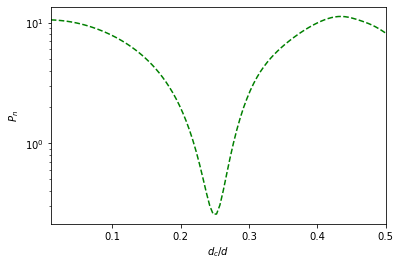

In [58]:
P_0 = 1.193

fig, ax = plt.subplots()
ax.plot(dc_vector, purcell_numerical / P_0, 'g--')

ax.set_xlim(min(dc_vector), max(dc_vector))

ax.set_yscale('log')
ax.set_xlabel(r'$d_c/d$')
ax.set_ylabel(r'$P_n$');

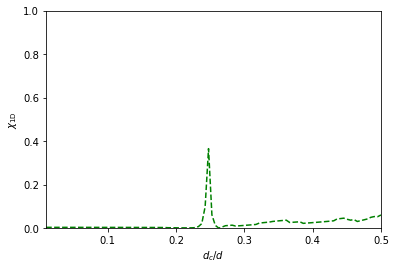

In [59]:
fig, ax = plt.subplots()
ax.plot(dc_vector, chi_1D, 'g--')

ax.set_xlim(min(dc_vector), max(dc_vector))

ax.set_ylim(0, 1)
ax.set_xlabel(r'$d_c/d$')
ax.set_ylabel(r'$\chi_\mathrm{1D}$');

The value of d_c / d = 0.451


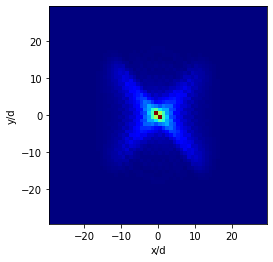

In [60]:
dc_target = 0.45
index = np.argmin(np.abs(dc_target - dc_vector))
print('The value of d_c / d = {:.3f}'.format(dc_vector[index]))

fig, ax = plt.subplots()
ax.imshow(real_space_emission[index], origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');